In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import numpy as np
from tensorflow.keras import callbacks
import warnings
import pandas as pd
warnings.simplefilter("ignore")

# Load data
data_folder = os.path.join('..', 'data')
data = util.load_cmapss_data(data_folder)

# Focus on a subset of the data
data_by_src = util.split_by_field(data, field='src')
dt = data_by_src['train_FD004']

# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]

tr, ts = util.partition_by_machine(dt, tr_mcn)

## Define a cost model
#failtimes = dt.groupby('machine')['cycle'].max()
#safe_interval = failtimes.min()
#maintenance_cost = failtimes.max()
#cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)

# Survival Analysis using Neural Models

## RUL Estimation, Again

**For our RUL estimation problem, we tried _two approaches_**

The _first_ consisted in using a regressor to estimate this kind of function:

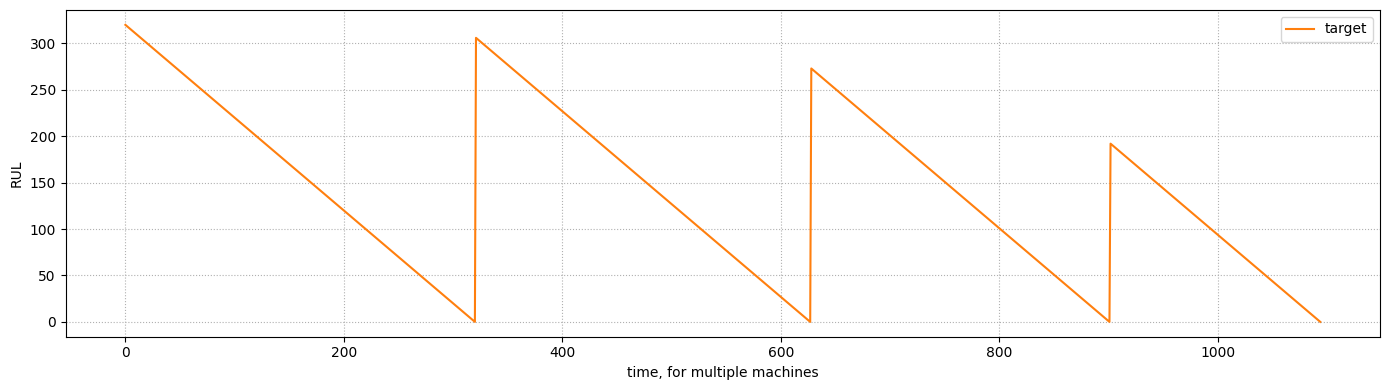

In [2]:
stop = 1095
util.plot_rul(target=tr['rul'][:stop], figsize=figsize, xlabel='time, for multiple machines', ylabel='RUL')

## RUL Estimation, Again

**For our RUL estimation problem, we tried _two approaches_**

The _second_ consisted in using a classifier to estimate this kind of function:

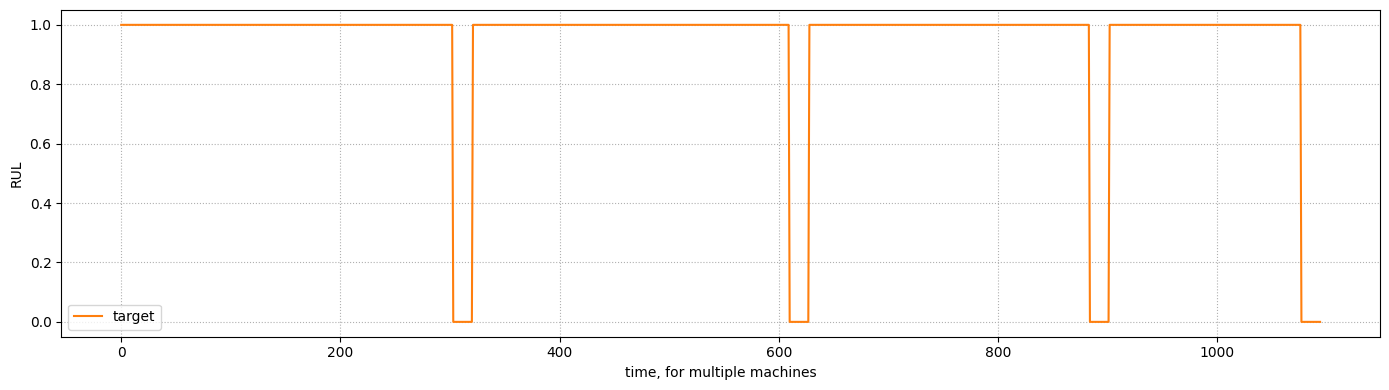

In [3]:
stop = 1095
util.plot_rul(target=(tr['rul'][:stop] >= 18), figsize=figsize, xlabel='time, for multiple machines', ylabel='RUL')

## Limitations

**Both approaches worked quite well on our dataset**

...But there was a price to pay

> **Can you tell which one?**

* We managed to obtain good maintenance policies
* ...But _no well-grounded RUL estimate_

**There are a few reasons**

* Failures are inherently stochastic
  - ...And we are treating them as deterministic phenomena
* We built our estimators without any underlying analysis
  - ...So the results are difficult to _motivate_ and to _interpret_

## Back to the Drawing Board

**Here's what the correct approach should be:**

* We start by defining a _probabilistic model_
* We use _ML to approximate_ key components of such model
* We use the model + the approximators to make _probabilistic predictions_

**This approach can be significantly more challenging**

...But it comes with several benefits:

* You have both predictions _and confidence_
* You exploit a degree of _domain knowledge_
* You get a _more interpretable_ model
* If you choose to _ignore_ an element (e.g. because it is too difficult to model)
* ...At least you _know_ that you have done so

## (Conditional) Survival Analysis

**We are interested in the "survival time" of an entity**

We can start by modeling that as a single random variable $T$ with unknown distribution

$$
T \sim P(T)
$$

* $T$ (with support in $\mathbb{R}^+)$ represents the survival time

**To be specific, we want $T$ to be _remaining_ survival time**

...With respect to time $t$ when we perform the estimation. Formally:

$$
T \sim P(T \mid t)
$$

* Now the distribution is conditioned on $t$ (which we can access)

## (Conditional) Survival Analysis

**Survival depends on additional factors**

E.g. on how the lifestyle of a person, or on how industrial equipment is used

* We can model these factor as additional random variables
* We can distinguish between behavior in the past $X_{\leq t}$ and the future $X_{>t}$

**Formally, we have:**

$$
T \sim P(T \mid X_{\leq t}, t, X_{> t})
$$

For now we focus on _capturing the elements that affect the estimate_

* We not not care (yet) about the fact that we can access them
* The idea is to focus on _one problem at a time_

## (Conditional) Survival Analysis

**...But of course whether a quantity can be accessed or not does matter**

In particular, _future behavior cannot be accessed_ at estimation time

* Intuitively, future behavior affects the estimate as _noise_
* Formally, we can _average out_ its effect

**This operation is called _marginalization_ and leads to:**

$$
T \sim \mathbb{E}_{X_{> t}} \left[ P(T \mid X_{\leq t}, t, X_{> t}) \right]
$$

This is a good model for the distribution we actually care about

* The "sawtooth like" target that we used earlier for RUL regression
* ....Corresponds to _samples from this distribution_

<div class="big"><small>In other words, we are saying our target was correct!</small><br>So, why did we get strange results in the RUL lecture?</div>

## Looking Back to Our Model

**In the RUL lecture we trained a regressor**

...With the current parameters/sensors as input nd an MSE loss

* Meaning were implicitly assuming this probabilistic model:

$$
T \sim \mathcal{N}(\mu(X_{t}), \sigma)
$$

* $\mathcal{N}$ denotes the Normal distribution, $\mu(\cdot)$ represents our old regressor

**Now, compare it with our new probabilistic model:**

$$
T \sim \mathbb{E}_{X_{> t}} \left[ P(T \mid X_{\leq t}, t, X_{> t}) \right]
$$

* Let's try to spot together any major difference

## Implicit Assumptions

**We made several implicit assumptions:**

$$
T \sim \mathcal{N}(\mu(X_{t}), \sigma) \quad \text{vs} \quad T \sim \mathbb{E}_{X_{> t}} \left[ P(T \mid X_{\leq t}, t, X_{> t}) \right]
$$

We considered _a single $X_{t}$_, rather than $X_{\leq t}$

* Actually, we tried that at least a bit (it helped, but not much)

We _disregarded time_ as an input

* ...And thankfully this is easy to fix

We assumed a _Normal distribution_ with _fixed variance_

* It's unclear how to relax the normality assumption
* ...But we know we can fix the variance this using a neuro-probabilistic model!

## About Time

**Let's fix one mistake by adding _time as an input_**

In our dataset, time corresponds to the "cycle" field

In [5]:
# Identify parameter and sensor columns
dt_in = list(data.columns[3:-1])

# Standardize parameters and sensors
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields
ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

# Normalize RUL and time (cycle)
trmaxrul = tr['rul'].max()
ts_s['cycle'] = ts_s['cycle'] / trmaxrul
tr_s['cycle'] = tr_s['cycle'] / trmaxrul
ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul

# Add time (cycle) to the input columns
dt_in = dt_in + ['cycle']

## Estimated Variance

**Then we can make our ML model capable of _estimating variance_**

In particular, we can use a neuro-probabilistic ML model

* The underlying probabilistic model is:

$$
T \sim \mathcal{N}(\mu(X_t, t), \sigma(X_t, t))
$$

In practice:

* We use conventional ML model (a network) to estimate $\mu$ and $\sigma$
* ...Then we feed both parameters to a `DistributionLambda` layer

**Our model will be able to learn how $\sigma$ depends on the input**

* This will be more challenging, but also more flexible
* ...And it will provide us confidence intervals

## Building a Neuro-Probabilistic Model

**Code to build the model can found in the `util` module**

```python
def build_nn_normal_model(input_shape, hidden, stddev_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    mu_logsigma = layers.Dense(2, activation='linear')(x)
    lf = lambda t: tfp.distributions.Normal(loc=t[:, :1], scale=tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsigma)
    model = keras.Model(model_in, model_out)
    return model
```

* Note the way the input tensor `t` is split in the `lambda` function
* That is needed to obtain the correct tensor shapes (columns)

## Building a Neuro-Probabilistic Model

**Let's build a simple neuro-probabilistic model**

2022-11-29 10:02:28.796823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


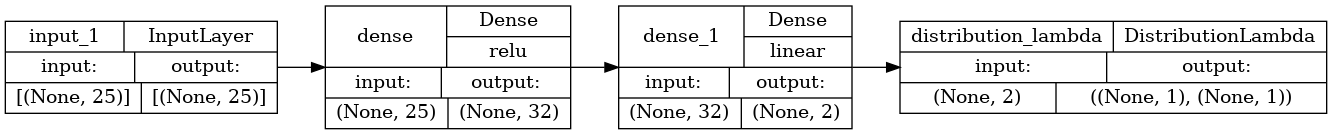

In [6]:
tr_rul_std = tr_s['rul'].std()
nnp = util.build_nn_normal_model(input_shape=(len(dt_in), ), hidden=[32], stddev_guess=tr_rul_std)
util.plot_nn_model(nnp)

* There is a single hidden layer
* As a guess for $\sigma$, we provide the standard deviations over the training set

## Training the Neuro-Probabilistic Model

**We can train the model as in our previous example**

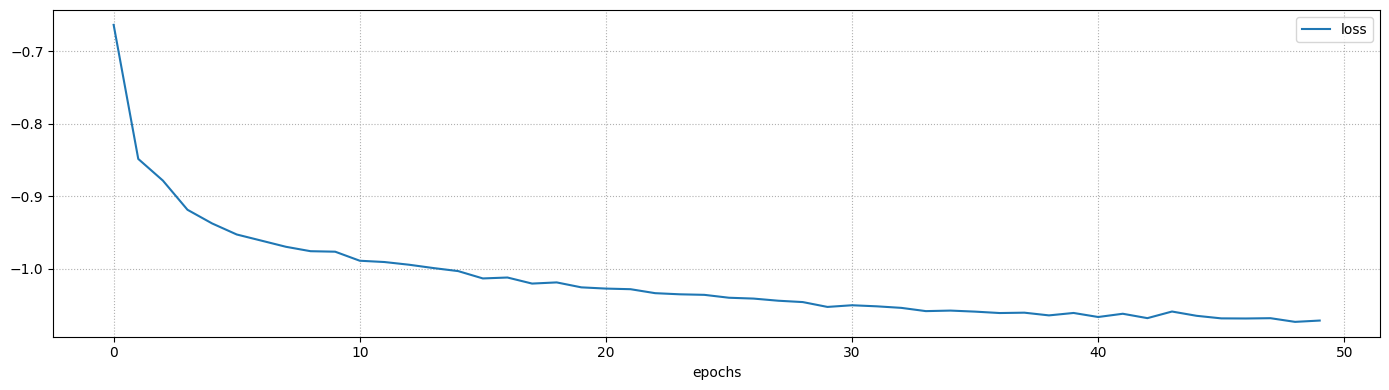

Final loss: -1.0716 (training)


In [7]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
nnp = util.build_nn_normal_model(input_shape=(len(dt_in), ), hidden=[32], stddev_guess=tr_rul_std)
history = util.train_nn_model(nnp, tr_s[dt_in], tr_s['rul'], loss=negloglikelihood, epochs=50, verbose=0, patience=10, batch_size=32, validation_split=0.0)
util.plot_training_history(history, figsize=figsize)

## Evaluation

**We care about the estimated distributions (not about sampling)**

...Therefore we call the model rather than using the `predict` method

In [8]:
nn_pred_ts = nnp(tr_s[dt_in].values)
nn_pred_ts

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[45385, 1] event_shape=[] dtype=float32>

**From the distribution objects we can obtain means and standard deviations**

In [9]:
np_pred_ts_mean = nn_pred_ts.mean().numpy().ravel() * trmaxrul
np_pred_ts_std = nn_pred_ts.stddev().numpy().ravel() * trmaxrul

* For sake of keeping it short, we will just inspect the predictions
* ...Rather than making a full evaluation

That said, we could do it (and the results would be similar to the old ones)

## Evaluation

**Let's inspect the predictions on a portion of the test set**

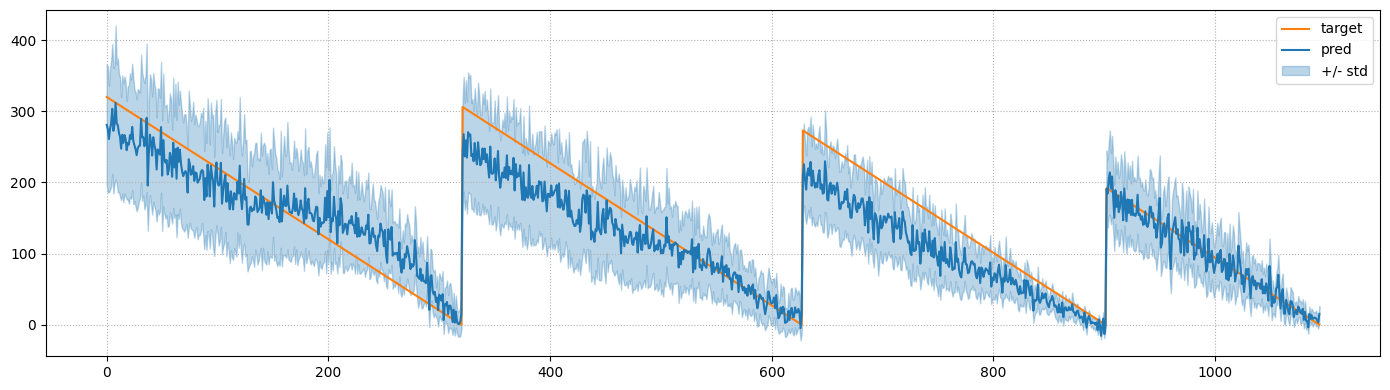

In [10]:
stop = 1095
util.plot_rul(target=tr_s['rul'].iloc[:stop]*trmaxrul, pred=np_pred_ts_mean[:stop],
              stddev=np_pred_ts_std[:stop], figsize=figsize)

* The initial plateaus in the predictions have disappeared
* ...And the true RUL is typically within 1$\sigma$ from the predicted mean

## Neuro-probabilistic Models vs Sample Weights

**The approach we have seen works already very well**

* We get a predicted mean (as usual)
* ...But also an input-dependent standard deviation

> **But can't we do the same with sample weights?**

**Yes, but it's not the same**

* Sample weights allow use to control the standard deviation with an MSE loss
* ...But we need to pre-compute them using another model (or assumption)

They cannot be learned in an end-to-end fashion!

## Open Issues

**But what if we are not confident about using a Normal?**

We could build a histogram from the target values

* ...But that would not be a conditional distribution
* ...And what if it yields something strange (e.g. a multi-modal distribution)?

**And what if the RUL depends strongly on when defects arise?**

* Then, in the early part of each run
* ...We might be accounting too much for what happened in the future

In practice, we risk overfitting (unless we have _a lot_ of runs)

## Survival Function

**We could study the distribution of $T$ via its _survival function_**

The survival function of a variable $T$ is defined as:

$$
S(t) = P(T > t)
$$

I.e. it the probability that the entity "survives" at least until time $t$

* It is the complement of the cumulative probability function $F(t) = P(T \leq t)$

**We can account for conditioning factors**

...And if we do it with $S$, we only care about _past_ behavior

$$
S(t, X_{\leq t}) = P(T > t \mid X_{\leq t})
$$

* This means _it cannot account for the future_
* ...But also that _it cannot overfit due to poor marginalization_

## ...And Hazard Function

**If we assume _discrete time_, then $S$ can be _factorized_**

$$
S(t, X_{\leq t}) = (1 - \lambda(t, X_{t})) (1 - \lambda(t-1, X_{t-1})) \ldots
$$

Where $\lambda$ is called _hazard function_

**The hazard function is _a conditional probability_**

...That of not making one more step, at time $t$. Formally:

* $\lambda(t, X_{t})$ is the probability of _not surviving_  at time $t$
* ...Given that the entity _has survived_ until time $t-1$. I.e.:

$$
\lambda(t, X_{t}) = P(T > t \mid T \geq t-1, X_{t})
$$

## Our Plan

**We will attempt to _train an estimator $\lambda(t, X_t, \theta)$_ for the hazard function**

* This requires _no assumption on the distribution_ (besides that of using $S$)
* It does _not risk_ overfitting due to _poor marginalization_
* And it makes sense even if we _do not observe a "death" event (censoring)_

As a side effect, we also _cannot account for future behavior_

**Additionally, it is not immediate to use $\lambda$ to obtain a RUL estimate**

...But we can use it to _approximate_ the chance of surviving $n$ steps from now

* In practice, we can approximately compute the conditional survival:

$$
S(t+n) / S(t) = P(T > t + n \mid T \geq t-1)
$$

* For many practical applications, this is enough

## Training a Hazard Estimator

**We still need to define how to train our $\lambda$ estimator**

...But at this point, we know enough to model the _probability of a survival event_

* Say the $k$-th experiment in our dataset ends at time $e_k$
* Then the corresponding probability according to our estimator is:

$$
\lambda(e_k, \hat{x}_{e_k}, \theta) \prod_{t = 1}^{e_k-1} (1 - \lambda(t, \hat{x}_{kt}, \theta))
$$

This is the probability of:

* Surviving all time steps from $1$ to $e_k-1$
* Not surviving at time $e_k$
* $\hat{x}_{kt}$ is the available input data for experiment $k$ at time $t$

## Training a Hazard Estimator

**We can now formulate a likelihood maximization problem**

Assuming we have $m$ experiments, we get:

$$
\mathop{\text{argmax}}_{\theta} \prod_{k=1}^{m} \lambda(e_k, \hat{x}_{e_k}, \theta) \prod_{t = 1}^{e_k-1} (1 - \lambda(t, \hat{x}_{kt}, \theta))
$$

* Let $\hat{d}_{kt} = 1$ iff $t = e_k$, i.e. if the experiment ends at time $k$
* ...And let $\hat{d}_{kt} = 0$ otherwise. Then we can rewrite the problem as:

$$
\mathop{\text{argmax}}_{\theta} \prod_{k=1}^{m} \prod_{t = 1}^{e_k} \hat{d}_{kt} \lambda(e_k, \hat{x}_{e_k}, \theta) + (1 - \hat{d}_{kt}) (1 - \lambda(t, \hat{x}_{kt}, \theta))
$$



## Training a Hazard Estimator

**Finally, with a log transformation and a sign switch we get:**

$$
\mathop{\text{argmin}_\theta} - \sum_{k=1}^{m} \sum_{t = 1}^{e_k} \hat{d}_{kt} \log \lambda(e_k, \hat{x}_{e_k}, \theta) + (1 - \hat{d}_{kt}) \log (1 - \lambda(t, \hat{x}_{kt}, \theta))
$$

This is a (binary) _crossentropy minimization_ problem!

* We just need to consider all samples in our dataset individually
* Then attach to them a class given by $\hat{d}_{kt}$
* ...And finally we can train a classifier

**This is almost precisely _what we did in our classification approach_**

* But now we know exactly how to define the classes

## Classes and Models

**Let's start by defining the classes**

We check when the RUL is 0 (this the same as $t = e_k$)

In [11]:
tr_lbl = (tr['rul'] == 0)
ts_lbl = (ts['rul'] == 0)

Then we can build a (usual) classification model:

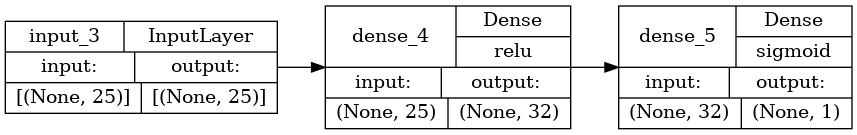

In [12]:
nnl = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[32], output_activation='sigmoid')
util.plot_nn_model(nnl)

## Training the Hazard Estimator

**We train the hazard estimator as any other classifier**

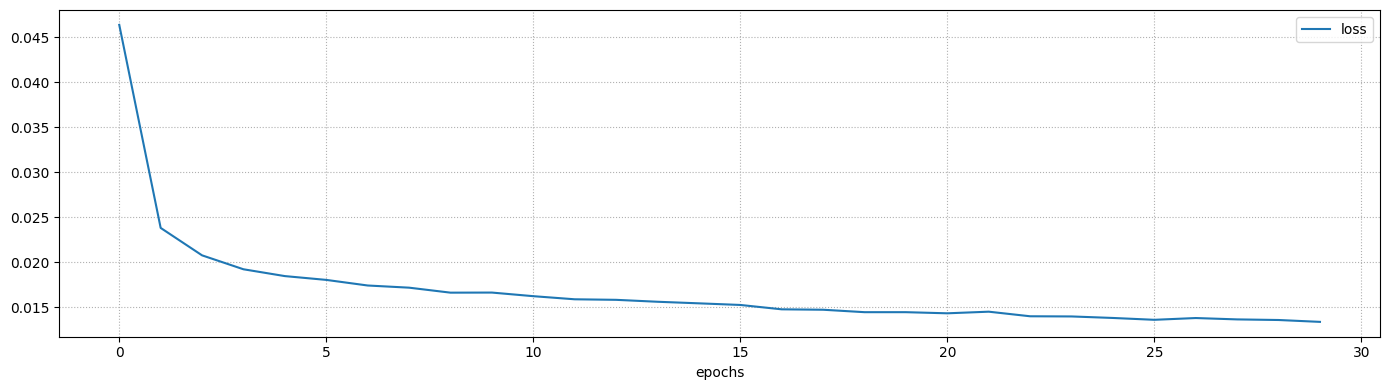

Final loss: 0.0134 (training)


In [13]:
nnl = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[32], output_activation='sigmoid')
history = util.train_nn_model(nnl, tr_s[dt_in], tr_lbl, loss='binary_crossentropy', epochs=30,
        verbose=0, patience=10, batch_size=32, validation_split=0.0)
util.plot_training_history(history, figsize=figsize)

## Inspecting Hazards

**We will start our evaluation by inspecting the hazard values**

First for (part of) the _training set_:

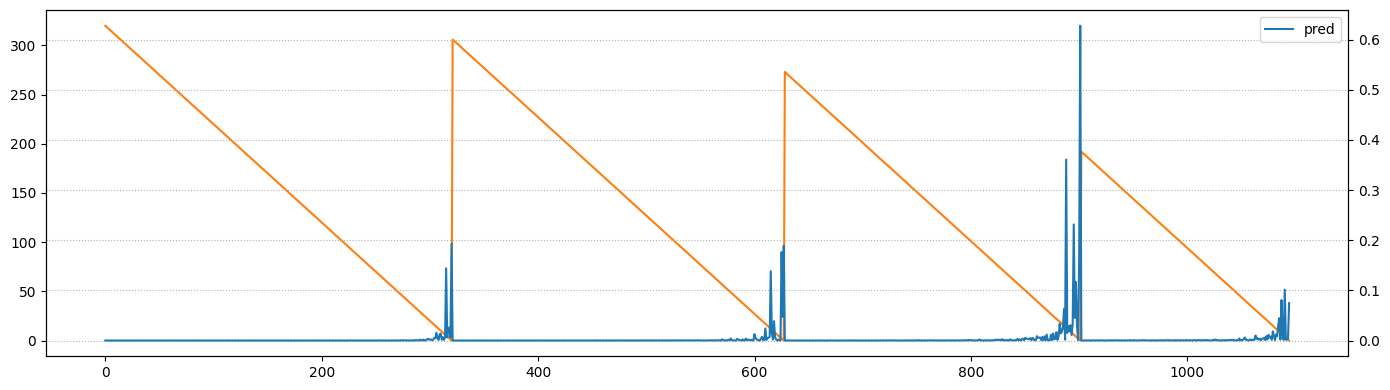

In [14]:
tr_pred = nnl.predict(tr_s[dt_in], verbose=0).ravel()
stop = 1095
util.plot_rul(pred=tr_pred[:stop], target=tr['rul'][:stop], same_scale=False, figsize=figsize)

## Inspecting Hazards

**We will start our evaluation by inspecting the hazard values**

...And here for (part of) the _test set_:

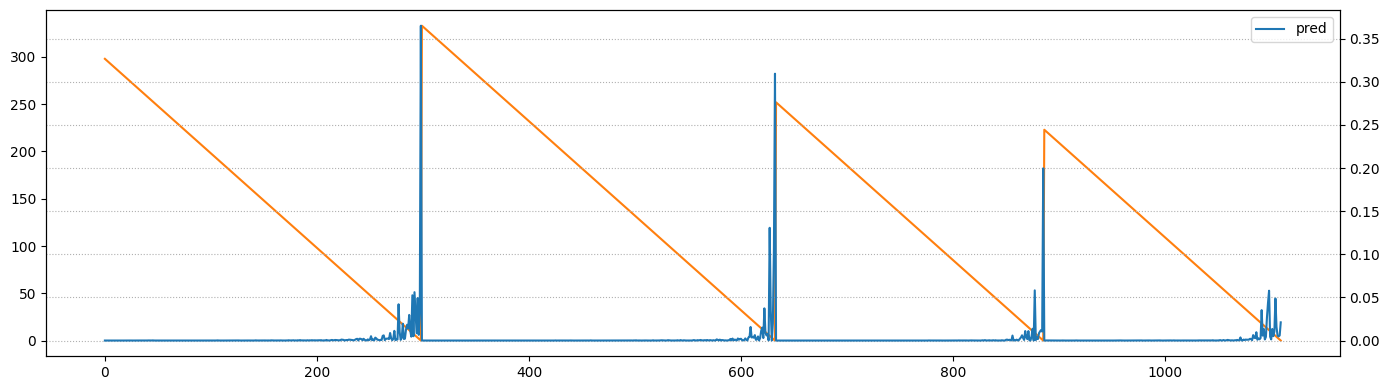

In [15]:
ts_pred = nnl.predict(ts_s[dt_in], verbose=0).ravel()
stop = 1110
util.plot_rul(pred=ts_pred[:stop], target=ts['rul'][:stop], same_scale=False, figsize=figsize)

## Beyond Simple Hazards

**These are hazard values, i.e. they refer to single steps**

* They could be used directly to formulate a maintenance policy
* To achieve that, we would just need to optimize a threshold

**...But it is more interesting to stick to our plan:**

We wish to compute the probability of being still up in $n$ steps

$$
S(t+n) / S(t) = \prod_{h=0}^{n} (1 - \lambda(t+h, X_{t+h}))
$$

By using our estimator (for a run $k$) we get:

$$
S(t+n) / S(t) \simeq \prod_{h=0}^{n} (1 - \lambda(t+h, \hat{x}_{k,t+h}, \theta))
$$

## Beyond Simple Hazards

**The formula requires access to _future values_ of the $X_t$ variable**

We cannot access those in real life, so we'll use an _approximation_:

$$
S(t+n) / S(t) \simeq \prod_{h=0}^{n} (1 - \lambda(t+h, \hat{x}_{kt}, \theta))
$$

* We keep the _sample values $\hat{x}_{kt}$ fixed_ (e.g. parameters & sensors)
* ...And we just _change the value of time_

**This trick has obvious limitations, however:**

* On a short horizon (small $n$), the error is typically limited
* It allows us to investigate the impact of time on the hazard $\lambda$

## Approximate Future Hazard 

**Let's check this approximate future hazard for one of our test runs**

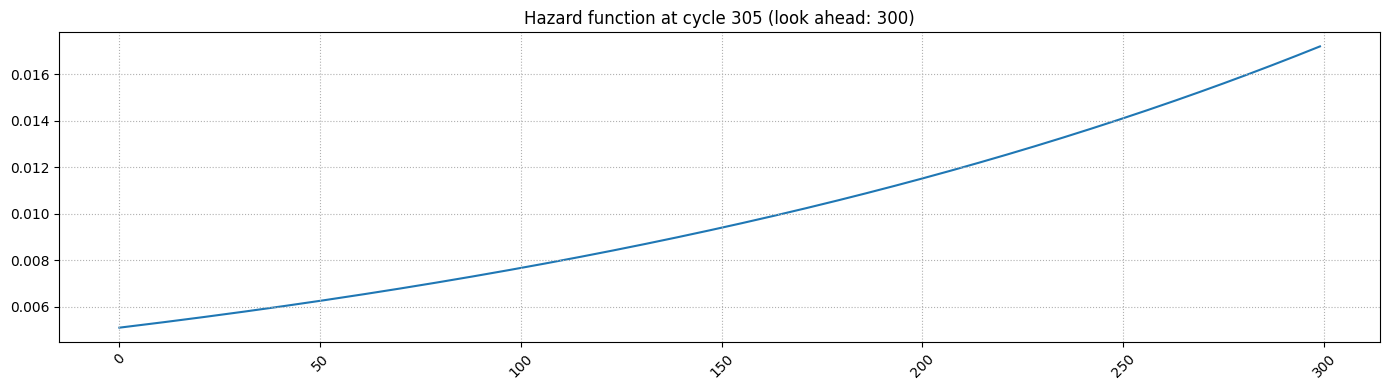

In [17]:
ref_sample = tr_s.iloc[304]
look_ahead = 300
hazard = util.predict_cf(nnl, ref_sample[dt_in], columns='cycle',
                         values=ref_sample['cycle'] + np.arange(look_ahead)/trmaxrul)
util.plot_series(hazard, figsize=figsize, title=f'Hazard function at cycle {ref_sample["cycle"]*trmaxrul:.0f} (look ahead: {look_ahead})')

* The model has learned that time has a super-linear effect on $\lambda$

## Approximate Conditional Survival

**We can use the approximate hazard to estimate conditional survival**

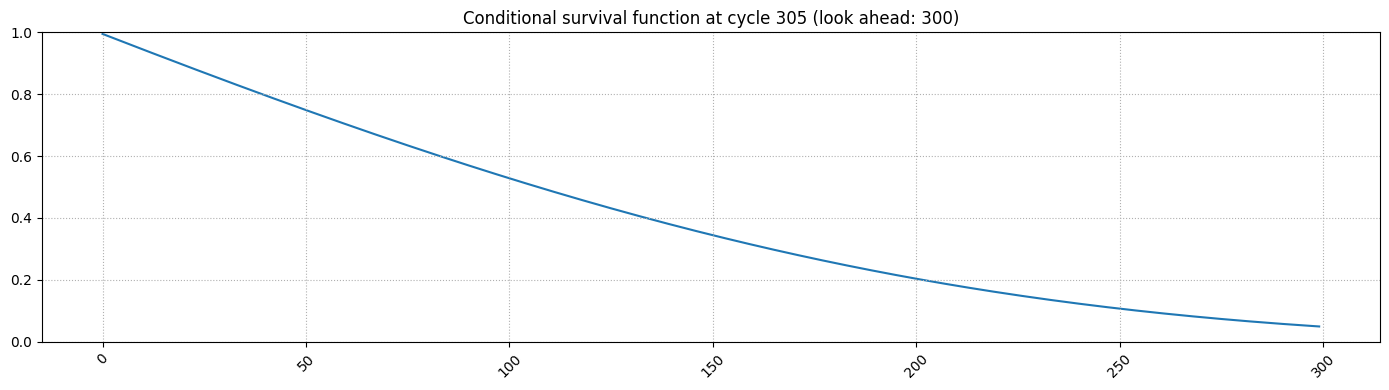

In [18]:
survival = pd.Series(data=np.cumprod(1-hazard))
util.plot_series(survival, figsize=figsize, ylim=(0,1),
                 title=f'Conditional survival function at cycle {ref_sample["cycle"]*trmaxrul:.0f} (look ahead: {look_ahead})')

The chance of being still running is smaller even in a few tens of steps

## Approximate Conditional Survival

**At deployment time, we could continuously compute conditional survival**

...Over a fixed look ahead window (e.g. 30 steps)

* Let's do it for a single experiment from our dataset:

In [19]:
ref_run = tr_s[tr_s['machine'] == tr_s.iloc[0]['machine']]
look_up_window = np.arange(30)/trmaxrul
rolling_survival = util.rolling_survival_cmapss(hazard_model=nnl, data=ref_run[dt_in], look_up_window=look_up_window)
rolling_survival.columns = [f'S(t+{h})/S(t)' for h in range(30)]
rolling_survival.head()

,S(t+0)/S(t),S(t+1)/S(t),S(t+2)/S(t),S(t+3)/S(t),S(t+4)/S(t),S(t+5)/S(t),S(t+6)/S(t),S(t+7)/S(t),S(t+8)/S(t),S(t+9)/S(t),...,S(t+20)/S(t),S(t+21)/S(t),S(t+22)/S(t),S(t+23)/S(t),S(t+24)/S(t),S(t+25)/S(t),S(t+26)/S(t),S(t+27)/S(t),S(t+28)/S(t),S(t+29)/S(t)
0,0.999998,0.999996,0.999994,0.999992,0.999990,0.999988,0.999986,0.999984,0.999982,0.999980,...,0.999957,0.999955,0.999953,0.999951,0.999949,0.999946,0.999944,0.999942,0.999940,0.999938
1,0.999999,0.999998,0.999997,0.999996,0.999995,0.999994,0.999993,0.999992,0.999992,0.999991,...,0.999980,0.999979,0.999978,0.999977,0.999976,0.999975,0.999974,0.999973,0.999972,0.999971
2,0.999997,0.999995,0.999992,0.999989,0.999987,0.999984,0.999981,0.999979,0.999976,0.999973,...,0.999943,0.999940,0.999937,0.999935,0.999932,0.999929,0.999926,0.999923,0.999920,0.999917
3,0.999998,0.999995,0.999993,0.999990,0.999988,0.999986,0.999983,0.999981,0.999979,0.999976,...,0.999949,0.999947,0.999944,0.999942,0.999939,0.999937,0.999934,0.999932,0.999929,0.999927
4,0.999981,0.999962,0.999943,0.999925,0.999906,0.999886,0.999867,0.999848,0.999829,0.999810,...,0.999593,0.999573,0.999553,0.999533,0.999513,0.999492,0.999472,0.999452,0.999431,0.999411


* Each column contains the conditional survival $h$ steps away

## Approximate Conditional Survival

**Here's a plot over time (after some smoothing)**

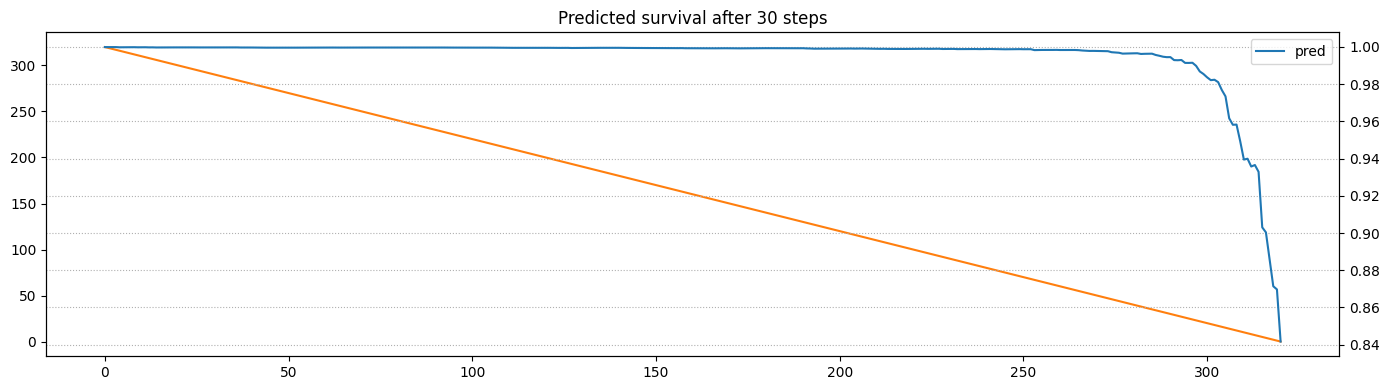

In [20]:
rolling_survival_last = rolling_survival[rolling_survival.columns[-1]].ewm(30).mean()
util.plot_rul(pred=rolling_survival_last[:stop], target=ref_run['rul']*trmaxrul, same_scale=False,
              figsize=figsize, title='Predicted survival after 30 steps')

* Remember that this is a stochastic phenomenon
* So, even a chance of 90% is quite dangerous to take!

## Hindsight

**This whole lecture block was about probabilistic models**

* The techniques we covered are interesting per-se
* ...And way more useful in practice than you might think

...But what the core message I hope you glimpsed is another

> **Machine Learning models are _not inflexible_ tools**

* If you spot a limit, or a piece of information you can use
* ...And you know what you are doing

**Then you can _dramatically change_ their behavior!**